In [1]:
# Importing libraries

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer, LabelEncoder

from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, StratifiedKFold, GridSearchCV, RandomizedSearchCV, train_test_split


# 일반적으로 회귀에는 기본 k-겹 교차검증을 사용하고, 분류에는 StratifiedKFold를 사용한다.

# 또한, cross_val_score 함수에는 KFold의 매개변수를 제어할 수가 없으므로, 

# 따로 KFold 객체를 만들고 매개변수를 조정한 다음에 cross_val_score의 cv 매개변수에 넣어야 한다.

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.naive_bayes import GaussianNB #Naive bayes
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix, make_scorer, r2_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

import warnings         # warnings : 버전 충돌 및 특정 예외 처리를 위해 불러온 내장 모듈
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
import sklearn.metrics as metrics

In [3]:
pd.set_option('display.max_row', 500)
pd.set_option('display.max_columns', 100)

# 1. EDA

In [4]:
train = pd.read_csv('./train.csv')

In [5]:
train.drop('index', axis = 1, inplace = True)

In [6]:
# 3,9 삭제.

idx_nm = train[(train['quality'] == 3) | (train['quality'] == 9)].index
train = train.drop(idx_nm)

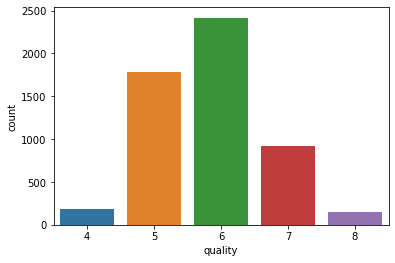

In [7]:
# 퀄리티별 빈도수

sns.countplot(x = 'quality', data = train)

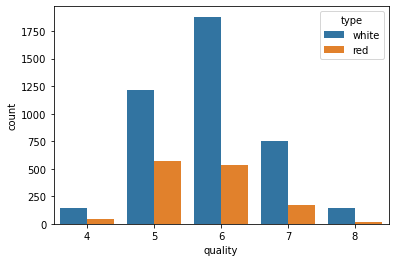

In [8]:
# 와인종류와 품질간의 관계

sns.countplot(x ='quality', hue = 'type', data = train)

In [9]:
train.columns

Index(['quality', 'fixed acidity', 'volatile acidity', 'citric acid',
       'residual sugar', 'chlorides', 'free sulfur dioxide',
       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol',
       'type'],
      dtype='object')

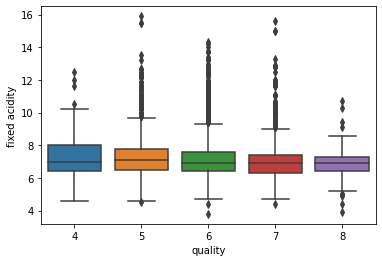

In [10]:
# quality 변수값에 따른 다른 변수들의 박스플롯

sns.boxplot(x = "quality", y = 'fixed acidity' , data = train)
plt.show()

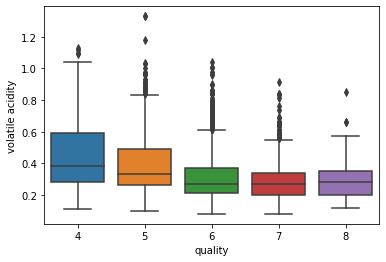

In [11]:
sns.boxplot(x = "quality", y = 'volatile acidity' , data = train)

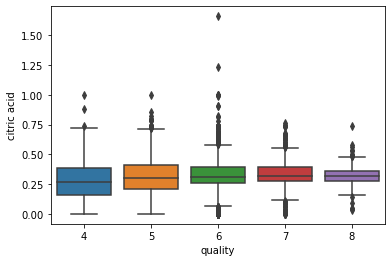

In [12]:
sns.boxplot(x = "quality", y = 'citric acid' , data = train)

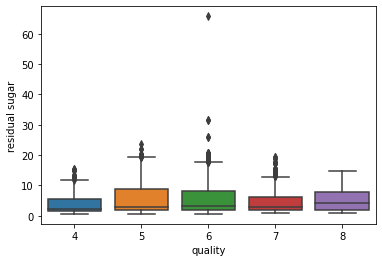

In [13]:
sns.boxplot(x = "quality", y = 'residual sugar' , data = train)

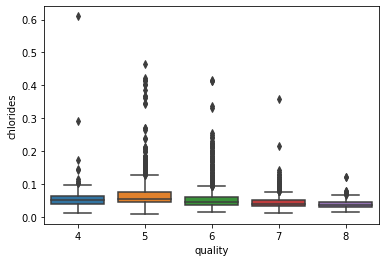

In [14]:
sns.boxplot(x = "quality", y = 'chlorides' , data = train)

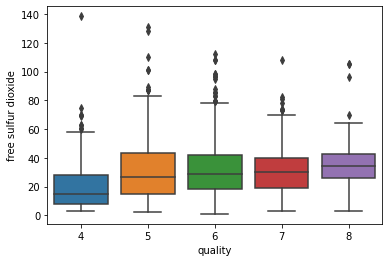

In [15]:
sns.boxplot(x = "quality", y = 'free sulfur dioxide' , data = train)

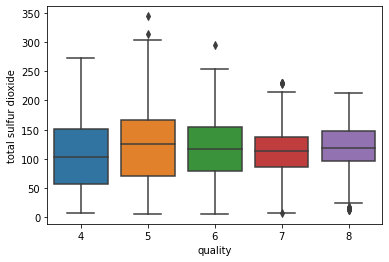

In [16]:
sns.boxplot(x = "quality", y = 'total sulfur dioxide' , data = train)

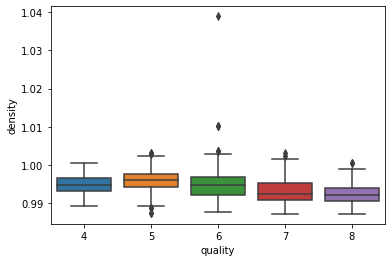

In [17]:
sns.boxplot(x = "quality", y = 'density' , data = train)

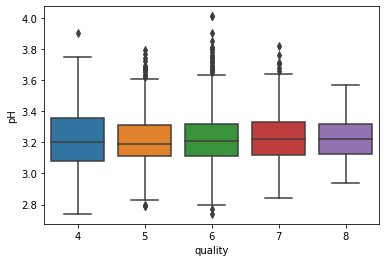

In [18]:
sns.boxplot(x = "quality", y = 'pH' , data = train)

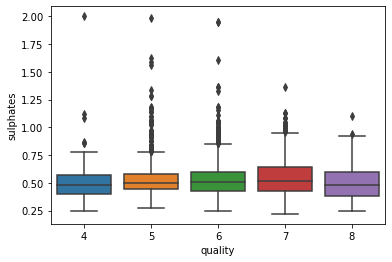

In [19]:
sns.boxplot(x = "quality", y = 'sulphates' , data = train)

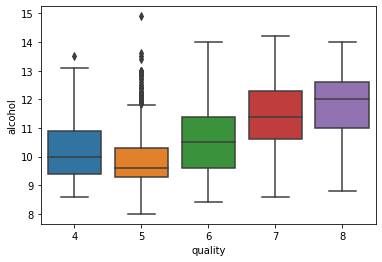

In [20]:
sns.boxplot(x = "quality", y = 'alcohol' , data = train)

In [21]:
train_corr = train.corr()

(12.5, -0.5)

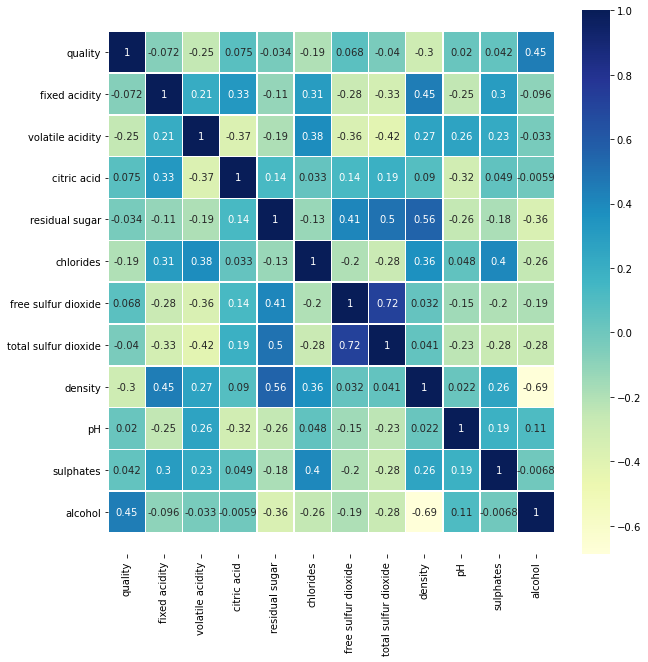

In [22]:
# 히트맵으로 상관계수 표현

fig, ax = plt.subplots(figsize = (10, 10))

sns.heatmap(train_corr,
            cmap = 'YlGnBu',
            xticklabels = train_corr.columns.values,
           yticklabels = train_corr.columns.values,
           annot = True, linewidths = .5, ax = ax)

b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values


In [23]:
# 더미변수 생성

df1 = pd.get_dummies(train['type'], prefix = 'type_' ,drop_first=False)

In [24]:
train = pd.concat([train, df1], axis=1 )
train.drop('type', axis = 1, inplace = True)

In [25]:
train.shape

(5466, 14)

# 2. 모델링

In [26]:
y = train['quality']
y.shape

(5466,)

In [27]:
X = train.drop('quality', axis=1)
X.shape

(5466, 13)

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, stratify = y)

### ADASYN
- ADASYN(Adaptive Synthetic Sampling) 방법은 소수 클래스 데이터와 그 데이터에서 가장 가까운 k개의 소수 클래스 데이터 중 무작위로 선택된 데이터 사이의 직선상에 가상의 소수 클래스 데이터를 만드는 방법이다.

In [29]:
from imblearn.over_sampling import *

In [30]:
X_train, y_train = ADASYN(random_state=0).fit_sample(X_train, y_train)

In [31]:
# 레이블 값 분포를 보기위한 코드.

train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape , X_test.shape))

print(' 학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 Shape:(9196, 13), 테스트 세트 Shape:(1094, 13)
 학습 세트 레이블 값 분포 비율
8    0.211505
4    0.210418
6    0.210091
7    0.194215
5    0.173771
Name: quality, dtype: float64

 테스트 세트 레이블 값 분포 비율
6    0.442413
5    0.327239
7    0.169104
4    0.033821
8    0.027422
Name: quality, dtype: float64


In [32]:
# logistic

log_cl =  LogisticRegression(n_jobs = -1)
log_cl.fit(X_train, y_train)
log_cl_pred = log_cl.predict(X_test)
print('Accuracy for logistic is ', metrics.accuracy_score(log_cl_pred, y_test))

log_cl_cv = cross_val_score(log_cl, X_train, y_train, cv = 10, scoring = 'accuracy', n_jobs=-1)
print('The cross validated score for logistic is:', log_cl_cv.mean())

Accuracy for rbf logistic is  0.23491773308957953
The cross validated score for logistic is: 0.35971199791834224


In [36]:
# Random forest

rf_cl = RandomForestClassifier(n_estimators = 1000, n_jobs = -1)
rf_cl.fit(X_train, y_train)
rf_cl_pred = rf_cl.predict(X_test)
print('The accuracy of the Random Forests is', metrics.accuracy_score(rf_cl_pred, y_test))

rf_cl_cv = cross_val_score(rf_cl, X_train, y_train, cv = 10, scoring = 'accuracy', n_jobs=-1)
print('The cross validated score for Random forest is:', rf_cl_cv.mean())

The accuracy of the Random Forests is 0.6380255941499086
The cross validated score for Random forest is: 0.8088319061361593


In [19]:
# Bagged KNN

ba_knn_model=BaggingClassifier(base_estimator = KNeighborsClassifier(n_neighbors=4), n_estimators=200, n_jobs=-1)
ba_knn_model.fit(X_train, y_train)
ba_knn_model_pred = ba_knn_model.predict(X_test)
print('The accuracy for bagged KNN is:', metrics.accuracy_score(ba_knn_model_pred, y_test))

ba_knn_model_cv = cross_val_score(ba_knn_model, X_train, y_train, cv=10, scoring = 'accuracy', n_jobs=-1)
print('The cross validated score for Bagged KNN is:', ba_knn_model_cv.mean())

The accuracy for bagged KNN is: 0.4287020109689214
The cross validated score for Bagged KNN is: 0.6687429537138533


In [20]:
# Bagged DecisionTree

ba_dt_model = BaggingClassifier(base_estimator = DecisionTreeClassifier(), random_state=0, n_estimators=100, n_jobs=-1)
ba_dt_model.fit(X_train, y_train)
ba_dt_model_pred = ba_dt_model.predict(X_test)
print('The accuracy for bagged Decision Tree is:', metrics.accuracy_score(ba_dt_model_pred, y_test))

ba_dt_model_cv = cross_val_score(ba_dt_model, X_train, y_train, cv = 10, scoring = 'accuracy', n_jobs=-1)
print('The cross validated score for bagged Decision Tree is:', ba_dt_model_cv.mean())

The accuracy for bagged Decision Tree is: 0.6279707495429616
The cross validated score for bagged Decision Tree is: 0.7915628746391744


In [21]:
# AdaBoost (Adaptive boosting)

ada_cl = AdaBoostClassifier(n_estimators = 200, learning_rate = 0.1)
ada_cl.fit(X_train, y_train)
ada_cl_pred = ada_cl.predict(X_test)
print('The accuracy for bagged Decision Tree is:', metrics.accuracy_score(ada_cl_pred, y_test))

ada_cl_cv = cross_val_score(ada_cl, X_train, y_train, cv = 10, scoring = 'accuracy', n_jobs = -1)
print('The cross validated score for AdaBoost is:', ada_cl_cv.mean())

The accuracy for bagged Decision Tree is: 0.3702010968921389
The cross validated score for AdaBoost is: 0.46274236433736443


In [22]:
# Gradient Boost

gr_grad = GradientBoostingClassifier(n_estimators = 200, learning_rate = 0.1)
gr_grad.fit(X_train, y_train)
gr_grad_pred = gr_grad.predict(X_test)
print('The accuracy for Gradient Boost is:', metrics.accuracy_score(gr_grad_pred, y_test))

gr_grad_cv = cross_val_score(gr_grad, X_train, y_train, cv = 10, scoring = 'accuracy', n_jobs = -1)
print('The cross validated score for Gradient Boosting is:', gr_grad_cv.mean())

The accuracy for Gradient Boost is: 0.5438756855575868
The cross validated score for Gradient Boosting is: 0.6861878280360145


In [23]:
# XGBoost

xgb_model = XGBClassifier(n_estimators = 200, learning_rate = 0.1)
xgb_model.fit(X_train,y_train)
xgb_model_pred = xgb_model.predict(X_test)
print('The accuracy of the XGBoost is', metrics.accuracy_score(xgb_model_pred, y_test))

xgb_model_cv = cross_val_score(xgb_model, X_train, y_train, cv = 10, scoring = 'accuracy', n_jobs = -1)
print('The cross validated score for XGBoost is:', xgb_model_cv.mean())

The accuracy of the XGBoost is 0.6288848263254113
The cross validated score for XGBoost is: 0.7759253099249662


In [35]:
# Light GBM

lgbm_clf = LGBMClassifier(n_estimators=400, n_jobs = -1)
lgbm_clf.fit(X_train, y_train)
lgbm_clf_pred = lgbm_clf.predict(X_test)
print('The accuracy of the Light GBM is', metrics.accuracy_score(lgbm_clf_pred, y_test))

lgbm_clf_cv = cross_val_score(lgbm_clf, X_train, y_train, cv = 10, scoring = 'accuracy', n_jobs = -1)
print('The cross validated score for Light GBM is:', lgbm_clf_cv.mean())

The accuracy of the Light GBM is 0.6535648994515539
The cross validated score for Light GBM is: 0.8145933881675844


In [25]:
results = pd.DataFrame({
    'Model': ['Logistic Classifier',
              'Random forest', 'Bagged KNN', 'Bagged DecisionTree', 'Adaptive Boost', 
              'Gradient Boost', 'XGBoost', 'Light GBM'],
    'Accuracy': [metrics.accuracy_score(log_cl_pred, y_test),  
                 metrics.accuracy_score(rf_cl_pred, y_test), metrics.accuracy_score(ba_knn_model_pred, y_test),
                 metrics.accuracy_score(ba_dt_model_pred, y_test), metrics.accuracy_score(ada_cl_pred, y_test),
                 metrics.accuracy_score(gr_grad_pred, y_test), metrics.accuracy_score(xgb_model_pred, y_test),
                 metrics.accuracy_score(lgbm_clf_pred, y_test)],
    'CV_Mean': [log_cl_cv.mean(), rf_cl_cv.mean(), ba_knn_model_cv.mean(),
                ba_dt_model_cv.mean(), ada_cl_cv.mean(), gr_grad_cv.mean(), 
                xgb_model_cv.mean(), lgbm_clf_cv.mean()],
    'CV_std':[log_cl_cv.std(), rf_cl_cv.std(), ba_knn_model_cv.std(),
                ba_dt_model_cv.std(), ada_cl_cv.std(), gr_grad_cv.std(), 
                xgb_model_cv.std(), lgbm_clf_cv.std()]
})

result = results.sort_values(by='CV_Mean', ascending=False)
result = result.set_index('Model')
display(result.head(13))

,Accuracy,CV_Mean,CV_std
Model,,,
Light GBM,0.649909,0.813661,0.032592
Random forest,0.659963,0.812596,0.018319
Bagged DecisionTree,0.627971,0.791563,0.016156
XGBoost,0.628885,0.775925,0.022995
Gradient Boost,0.543876,0.686188,0.024705
Bagged KNN,0.428702,0.668743,0.017401
Adaptive Boost,0.370201,0.462742,0.016648
Logistic Classifier,0.247715,0.381461,0.032185


# 3. 하이퍼파라미터 수정 - Random Forest

# GridsearchCV

In [26]:
### Random forest 하이퍼파라미터 수정

hyper = { 'n_estimators' : [10, 100],
           'max_depth' : [6, 8, 10, 12],
           'min_samples_leaf' : [8, 12, 18],
           'min_samples_split' : [8, 16, 20]
            }

gd_rf = GridSearchCV(estimator = RandomForestClassifier(), param_grid = hyper, verbose = True, n_jobs=-1)
gd_rf.fit(X_train,y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  1.2min finished


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [6, 8, 10, 12],
                         'min_samples_leaf': [8, 12, 18],
                         'min_samples_split': [8, 16, 20],
                         'n_estimators': [10, 100]},
             verbose=True)

In [27]:
gd_rf.best_estimator_

RandomForestClassifier(max_depth=12, min_samples_leaf=8, min_samples_split=8)

In [30]:
rf_gd_best = RandomForestClassifier(max_depth=12, min_samples_leaf=8, min_samples_split=8)

In [31]:
rf_gd_best.fit(X_train, y_train)

RandomForestClassifier(max_depth=12, min_samples_leaf=8, min_samples_split=8)

## Randomized SearchCV

In [17]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split

max_features = ['auto', 'sqrt']

# Maximum number of levels in tree

max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]

max_depth.append(None)

# Minimum number of samples required to split a node

min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node

min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree

bootstrap = [True, False]

# Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

# {'bootstrap': [True, False],
#  'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
#  'max_features': ['auto', 'sqrt'],
#  'min_samples_leaf': [1, 2, 4],
#  'min_samples_split': [2, 5, 10],
#  'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [18]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune

rf = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, n_jobs = -1)

# Fit the random search model

rf_random.fit(X_train, y_train)
print(rf_random.best_score_)
print(rf_random.best_estimator_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 15.6min finished


0.7913807108062185
RandomForestClassifier(bootstrap=False, max_depth=90, max_features='sqrt',
                       n_estimators=1200)


In [21]:
rf_random_best = RandomForestClassifier(bootstrap=False, max_depth=90, max_features='sqrt',
                       n_estimators=1200)

In [22]:
rf_random_best.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=90, max_features='sqrt',
                       n_estimators=1200)

# 4. 제출용 테스트데이터 생성

In [23]:
test = pd.read_csv('./test.csv')

In [24]:
test.drop('index', axis = 1, inplace = True)

In [25]:
test.shape

(1000, 12)

In [26]:
# 더미변수 생성

df1 = pd.get_dummies(test['type'], prefix = 'type_' ,drop_first=False)

In [27]:
test = pd.concat([test, df1], axis=1 )
test.drop('type', axis = 1, inplace = True)

# 5. 제출용파일생성

### 5-1. 랜덤포레스트 최적(x)

In [29]:
rf_cl_pred = rf_cl.predict(test)
rf_cl_pred = pd.DataFrame(rf_cl_pred)
submit = pd.read_csv('./sample_submission.csv')
submit['quality'] = rf_cl_pred[0]
submit.to_csv('./sub_rf_cl.csv', index = False)

### 5-2. 랜덤포레스트 튜닝모델

In [64]:
rf_gd_best.fit(X_train, y_train)

In [65]:
rf_random_best.fit(X_train, y_train)

RandomForestClassifier(max_depth=12, min_samples_leaf=8, min_samples_split=16,
                       n_jobs=-1)

In [32]:
rf_gd_best_pred = rf_gd_best.predict(test)
rf_gd_best_pred = pd.DataFrame(rf_gd_best_pred)
submit = pd.read_csv('./sample_submission.csv')
submit['quality'] = rf_gd_best_pred[0]
submit.to_csv('./sub_rf_gd_best.csv', index = False)

In [34]:
rf_random_best_pred = rf_random_best.predict(test)
rf_random_best_pred = pd.DataFrame(rf_random_best_pred)
submit = pd.read_csv('./sample_submission.csv')
submit['quality'] = rf_random_best_pred[0]
submit.to_csv('./sub_rf_random_best.csv', index = False)

### 5-3. Light GBM 최적(x)

In [37]:
lgbm_clf.fit(X_train, y_train)

LGBMClassifier(n_estimators=400)

In [36]:
lgbm_clf_pred = lgbm_clf.predict(test)
lgbm_clf_pred = pd.DataFrame(lgbm_clf_pred)
submit = pd.read_csv('./sample_submission.csv')
submit['quality'] = lgbm_clf_pred[0]
submit.to_csv('./sub_lgbm_clf.csv', index = False)

### 5-4. Light GBM 최적(o)

In [38]:
lg_best = LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', lambda_l1=1, lambda_l2=1,
               learning_rate=0.1, max_depth=-1, min_child_samples=20,
               min_child_weight=0.001, min_data_in_leaf=30, min_split_gain=0.0,
               n_estimators=200, n_jobs=-1, num_leaves=127, objective=None,
               random_state=None, reg_alpha=0.1, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [39]:
lg_best.fit(X_train, y_train)

LGBMClassifier(lambda_l1=1, lambda_l2=1, min_data_in_leaf=30, n_estimators=200,
               num_leaves=127, reg_alpha=0.1)

In [40]:
lg_best_pred = lg_best.predict(test)
lg_best_pred = pd.DataFrame(lg_best_pred)
submit = pd.read_csv('./sample_submission.csv')
submit['quality'] = lg_best_pred[0]
submit.to_csv('./sub_lg_best.csv', index = False)

### Borderline - SMOTE

In [41]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, stratify = y)

In [42]:
X_train, y_train = BorderlineSMOTE(random_state=0).fit_sample(X_train, y_train)

In [43]:
# 레이블 값 분포를 보기위한 코드.

train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape , X_test.shape))

print(' 학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 Shape:(9660, 13), 테스트 세트 Shape:(1094, 13)
 학습 세트 레이블 값 분포 비율
7    0.2
6    0.2
5    0.2
4    0.2
8    0.2
Name: quality, dtype: float64

 테스트 세트 레이블 값 분포 비율
6    0.442413
5    0.327239
7    0.169104
4    0.033821
8    0.027422
Name: quality, dtype: float64


In [44]:
# Random forest

rf_cl = RandomForestClassifier(n_estimators = 1000, n_jobs = -1)
rf_cl.fit(X_train, y_train)
rf_cl_pred = rf_cl.predict(X_test)
print('The accuracy of the Random Forests is', metrics.accuracy_score(rf_cl_pred, y_test))

rf_cl_cv = cross_val_score(rf_cl, X_train, y_train, cv = 10, scoring = 'accuracy', n_jobs=-1)
print('The cross validated score for Random forest is:', rf_cl_cv.mean())

The accuracy of the Random Forests is 0.6563071297989032
The cross validated score for Random forest is: 0.8408902691511388


In [45]:
# Light GBM

lgbm_clf = LGBMClassifier(n_estimators=400, n_jobs = -1)
lgbm_clf.fit(X_train, y_train)
lgbm_clf_pred = lgbm_clf.predict(X_test)
print('The accuracy of the Light GBM is', metrics.accuracy_score(lgbm_clf_pred, y_test))

lgbm_clf_cv = cross_val_score(lgbm_clf, X_train, y_train, cv = 10, scoring = 'accuracy', n_jobs = -1)
print('The cross validated score for Light GBM is:', lgbm_clf_cv.mean())

The accuracy of the Light GBM is 0.6453382084095064
The cross validated score for Light GBM is: 0.8425465838509318


# END